In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from scipy.stats import t, f, chi2
from itertools import combinations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.stats.sandwich_covariance as sc
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
import pdb

In [2]:
alpha = np.array([1, -1]).reshape(-1,1)
phi1 = np.array([[0.2, -0.1],
                 [0, -0.25]])
gamma1 = np.array([0, 0.3]).reshape(-1,1)
gamma2 = np.array([0, 0.03]).reshape(-1,1)
gamma3 = np.array([-0.25, 0.1]).reshape(-1,1)
gamma4 = np.array([-0, 0]).reshape(-1,1)
gamma_list = [gamma1, gamma2, gamma3, gamma4]
T_list = [250, 2500]

In [3]:
def simulate_VECM1(alpha, phi, gamma, nsample):
    '''single simulation'''
    x10, x11 = np.random.normal(0,1,2)
    x20, x21 = np.random.normal(0,1,2)
    x1tm2, x1tm1 = x10, x11
    x2tm2, x2tm1 = x20, x21
    del_x1tm1 = x1tm1 - x1tm2
    del_x2tm1 = x2tm1 - x2tm2
    Xtm1 = np.array([x1tm1, x2tm1]).reshape(-1,1)
    Xtm2 = np.array([x2tm2, x2tm2]).reshape(-1,1)
    Xt_array = np.empty([2,nsample])
    
    for i in range(nsample):
        del_Xtm1 = Xtm1 - Xtm2
        ztm1 = alpha.T @ Xtm1
        e1t, e2t = np.random.normal(0,1,2)
        Et = np.array([e1t, e2t]).reshape(-1,1)
        del_Xt = gamma @ ztm1 + phi @ del_Xtm1 + Et
        Xt = del_Xt + Xtm1
        Xt_array[:,i] = Xt.flatten()

        Xtm2 = Xtm1
        Xtm1 = Xt
        
    return Xt_array.T

In [4]:
def estimate_VECM1(alpha, Xt_array):
    x1t_vec = Xt_array[:, 0] # 1d array
    x2t_vec = Xt_array[:, 1]
    x1tm1_vec = x1t_vec[:-1]
    x2tm1_vec = x2t_vec[:-1]
    del_x1t_vec = np.diff(x1t_vec, axis=0) 
    del_x2t_vec = np.diff(x2t_vec, axis=0)
    del_x1tm1_vec = del_x1t_vec[:-1]
    del_x2tm1_vec = del_x2t_vec[:-1]
    del_x1t_vec = del_x1t_vec[1:]
    del_x2t_vec = del_x2t_vec[1:]
    ztm1 = alpha.item(0,0) * x1tm1_vec + alpha.item(1,0) * x2tm1_vec
    ztm1 = ztm1[1:]
    regressors = np.concatenate((ztm1.reshape(-1,1), del_x1tm1_vec.reshape(-1,1), del_x2tm1_vec.reshape(-1,1)), axis=1)
    ols_result_x1 = sm.OLS(del_x1t_vec, regressors).fit(cov_type='HC1')
    ols_result_x2 = sm.OLS(del_x2t_vec, regressors).fit(cov_type='HC1')
    return ols_result_x1, ols_result_x2

In [5]:
def estimate_VAR(lagp, Xt_array):
    x1t_vec = Xt_array[:, 0] # 1d array
    x2t_vec = Xt_array[:, 1]  
    x1tmp_vec_list = [x1t_vec[lagp-p:-p] for p in range(1,lagp+1)]
    x2tmp_vec_list = [x2t_vec[lagp-p:-p] for p in range(1,lagp+1)]
    x1t_vec = x1t_vec[lagp:]
    x2t_vec = x2t_vec[lagp:]
    xtmp_vec_list = [j for i in zip(x1tmp_vec_list, x2tmp_vec_list) for j in i]
    first_col = xtmp_vec_list[0].reshape(-1,1)
    regressors = first_col
    for i in range(1, len(xtmp_vec_list)):
        regressors = np.concatenate((regressors, xtmp_vec_list[i].reshape(-1,1)), axis=1)
    ols_result_x1 = sm.OLS(x1t_vec, regressors).fit(cov_type='HC1')
    ols_result_x2 = sm.OLS(x2t_vec, regressors).fit(cov_type='HC1')
    return ols_result_x1, ols_result_x2
    

In [6]:
def estimate_LH(alpha, kahead, Xt_array, cov_type='HC1', diff=False, **kwargs):
    x1t_vec = Xt_array[:, 0] # 1d array
    x2t_vec = Xt_array[:, 1]
    x1tpk_vec_list = [x1t_vec[k:-(kahead-k)] for k in range(1,kahead)] + [x1t_vec[kahead:]]
    x2tpk_vec_list = [x2t_vec[k:-(kahead-k)] for k in range(1,kahead)] + [x2t_vec[kahead:]]
    x1deltpk_vec_list = [np.diff(x1deltpk) for x1deltpk in x1tpk_vec_list]
    x2deltpk_vec_list = [np.diff(x2deltpk) for x2deltpk in x2tpk_vec_list]
    x1_sum_list = x1deltpk_vec_list if diff else x1tpk_vec_list
    x2_sum_list = x2deltpk_vec_list if diff else x2tpk_vec_list
    x1t_vec = x1t_vec[:-(kahead+1)] if diff else x1t_vec[:-kahead]
    x2t_vec = x2t_vec[:-(kahead+1)] if diff else x2t_vec[:-kahead]
    zt = alpha.item(0,0) * x1t_vec + alpha.item(1,0) * x2t_vec
    regressors = sm.add_constant(zt)
    x1_sum = np.zeros(x1_sum_list[0].shape)
    x2_sum = np.zeros(x2_sum_list[0].shape)
    for x1, x2 in zip(x1_sum_list, x2_sum_list):
        x1_sum += x1
        x2_sum += x2
    ols_result_x1 = sm.OLS(x1_sum, regressors).fit(cov_type=cov_type, **kwargs)
    ols_result_x2 = sm.OLS(x2_sum, regressors).fit(cov_type=cov_type, **kwargs) 
    return ols_result_x1, ols_result_x2

In [7]:
def ADF(data, nlags, const=True):
    '''Regression without constanta and trend'''
    delta_zt = data.diff(periods=1).dropna()
    zt_m1 = data.shift(periods=1).dropna()
    df = zt_m1
    for i in range(1, nlags+1):
        delta_zt_mi = delta_zt.shift(periods=i)
        df = pd.concat([df, delta_zt_mi], axis=1)
    df = df.dropna()
#     ols_ADF = ols(delta_zt[nlags:], df, intercept=False, White=False)
#     ADF = ols_ADF["Beta"].item(0)/ols_ADF["Standard errors"].item(0)
    X = df.to_numpy()
    X = sm.add_constant(X) if const else X
    model = sm.OLS(delta_zt[nlags:], X).fit()
    ADF = model.params[1]/model.bse[1] if const else model.params[0]/model.bse[0]
    pvalue = mackinnonp(ADF, regression="c", N=1)
    return ADF, pvalue

In [8]:
def BG(ols_results, nlags):
    e = ols_results.resid.reshape(-1,1)
    n = ols_results.nobs
    e_lag = np.empty((e.shape))
    for i in range(1, nlags+1):
        lag_i = np.append(np.zeros(i).reshape(-1,1), e[:-i,:], axis=0)
        e_lag = np.append(e_lag, lag_i, axis=1)
    e_lag = e_lag[nlags:,1:]
    e_trim = e[nlags:,:]
    ols_results = sm.OLS(e_trim, e_lag).fit()
    R_squared = ols_results.rsquared
    chi2_test = (n-nlags)*R_squared
    p_value = chi2.sf(chi2_test, nlags)
    return p_value

In [9]:
def White_test(ols_results, regressors):
    X = regressors
    n = int(ols_results.nobs)
    resid = ols_results.resid
#     for i in range(X.shape[1]):
#         if np.array_equal(X[:,i], np.ones(n)):
#             const_idx = i  
#     X = np.delete(X, const_idx, 1)
    n_col = X.shape[1]
    comb = combinations(list(range(n_col)), 2)
    X_squared = np.square(X)
    X_comb = np.empty([X.shape[0],0])
    for i, j in comb:
        X_comb = np.append(X_comb, np.multiply(X[:,i].reshape(-1,1), X[:,j].reshape(-1,1)), axis=1)
    X_White = np.concatenate((X, X_squared, X_comb), axis=1)
    X_White = sm.add_constant(X_White)
    au_reg_results = sm.OLS(resid**2, X_White).fit()
    nR_squared = n * au_reg_results.rsquared
    df = X_White.shape[1]
    p_value = chi2.sf(nR_squared, df)
    results = {"nR^2": nR_squared, "P-value": p_value}
    return p_value

## Q4

### (a)

In [10]:
vecm_result_dict = {}
var_result_dict = {}
var_del_result_dict = {}
LH_result_dict = {}
ADF_result_dict = {}
for T in T_list:
    for i, g in enumerate(gamma_list):
        sim_result = simulate_VECM1(alpha=alpha, phi=phi1, gamma=g, nsample=T)
        del_sim_result = np.diff(sim_result, axis=0)
        vecm_x1, vecm_x2 = estimate_VECM1(alpha=alpha, Xt_array=sim_result)
        vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)] = vecm_x1
        vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)] = vecm_x2
        ADF_result_dict["T:{}, Gamma:{}, x1".format(T, i)] = tsa.stattools.adfuller(sim_result[:, 0])[1]
        ADF_result_dict["T:{}, Gamma:{}, x2".format(T, i)] = tsa.stattools.adfuller(sim_result[:, 1])[1]
        for p in range(1, 10+1):
            var_x1, var_x2 = estimate_VAR(lagp=p, Xt_array=sim_result)
            var_del_x1, var_del_x2 = estimate_VAR(lagp=p, Xt_array=del_sim_result)
            var_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, p)] = var_x1
            var_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, p)] = var_x2
            var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, p)] = var_del_x1
            var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, p)] = var_del_x2
        for k in range(1,10+1):
            LH_x1, LH_x2 = estimate_LH(alpha, k, sim_result)
            LH_result_dict["T:{}, Gamma:{}, K: {}, x1".format(T, i, k)] = LH_x1
            LH_result_dict["T:{}, Gamma:{}, K: {}, x2".format(T, i, k)] = LH_x2

In [11]:
for T in T_list:
    for i, g in enumerate(gamma_list):
        vecm_BIC_df = pd.DataFrame({"x1": pd.Series(data = vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].bic,
                                                    index = [1]),
                                    "x2": pd.Series(data = vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].bic,
                                                    index = [1]),
                                   }
                                  )
        var_BIC_df = pd.DataFrame({"x1": pd.Series(data = [var_result_dict["T:{}, Gamma:{}, Lag: {}, x1"\
                                                                .format(T, i, p)].bic for p in range(1, 10+1)],
                                                   index = range(1, 10+1)),
                                   "x2": pd.Series(data = [var_result_dict["T:{}, Gamma:{}, Lag: {}, x2"\
                                                                .format(T, i, p)].bic for p in range(1, 10+1)],
                                                   index = range(1, 10+1)),
                                   "del_x1": pd.Series(data = [var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1"\
                                                                .format(T, i, p)].bic for p in range(1, 10+1)],
                                                   index = range(1, 10+1)),
                                   "del_x2": pd.Series(data = [var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x2"\
                                                                .format(T, i, p)].bic for p in range(1, 10+1)],
                                                   index = range(1, 10+1))
                                  }
                                 )
        var_avg = (var_BIC_df["x1"] + var_BIC_df["x2"])/2
        del_var_avg = (var_BIC_df["del_x1"] + var_BIC_df["del_x2"])/2
        var_BIC_df = pd.concat([var_BIC_df, var_avg, del_var_avg], axis=1)
        var_BIC_df.rename(columns = {0:'(x1+x2)/2', 1:"(del_x1+del_x2)/2"}, inplace = True) 
        vecm_BIC_df.index.names = ["VECM p lags"]
        var_BIC_df.index.names = ["VAR p lags"]
        print("BIC values for T = {} and Gamma = {}".format(T, g.flatten()))
#         display(vecm_BIC_df)
        display(var_BIC_df)
        print("\n\n\n")

BIC values for T = 250 and Gamma = [0.  0.3]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,715.197459,732.708883,699.939973,764.272537,723.953171,732.106255
2,710.146487,716.878245,708.473317,762.415590,713.512366,735.444454
3,718.632287,718.593655,716.728479,758.776085,718.612971,737.752282
4,726.804536,725.174047,725.780932,757.635966,725.989292,741.708449
5,735.822153,733.897486,732.107326,760.497349,734.859819,746.302337
6,741.899708,740.077161,740.219300,766.975372,740.988434,753.597336
7,749.831566,749.114019,746.930849,775.810835,749.472793,761.370842
8,756.893321,754.894553,754.051409,777.200272,755.893937,765.625841
9,764.002400,758.854771,762.518410,776.387012,761.428586,769.452711






BIC values for T = 250 and Gamma = [0.   0.03]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,741.288753,733.559913,718.733384,727.969590,737.424333,723.351487
2,729.534215,726.682805,727.753367,736.869811,728.108510,732.311589
3,738.451118,735.426103,734.374389,741.925463,736.938611,738.149926
4,745.307399,741.983886,742.371799,748.467720,743.645642,745.419759
5,753.331154,748.343790,749.714302,755.524565,750.837472,752.619433
6,760.642966,754.468316,756.817224,764.233493,757.555641,760.525359
7,767.757652,762.959710,765.609364,770.767890,765.358681,768.188627
8,776.556160,766.395686,772.223178,777.950386,771.475923,775.086782
9,782.954495,775.296584,776.519308,781.248665,779.125539,778.883986






BIC values for T = 250 and Gamma = [-0.25  0.1 ]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,745.770491,760.780906,763.085375,740.061543,753.275699,751.573459
2,737.804243,726.621028,760.322744,743.022196,732.212635,751.672470
3,746.035307,733.460256,764.725926,747.914002,739.747782,756.319964
4,754.254521,739.217419,771.636034,744.077485,746.735970,757.856759
5,761.937152,743.162819,777.698632,750.406466,752.549986,764.052549
6,769.461850,749.982137,784.305771,755.319697,759.721993,769.812734
7,773.996830,754.932101,791.701798,763.657289,764.464466,777.679544
8,781.320463,763.625410,797.478555,771.501736,772.472937,784.490145
9,788.823056,772.555697,805.463383,776.296931,780.689376,790.880157






BIC values for T = 250 and Gamma = [0 0]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,744.054316,717.315678,730.583121,691.379749,730.684997,710.981435
2,739.423084,701.902940,737.896323,690.144092,720.663012,714.020207
3,746.941967,701.007873,744.774986,693.591144,723.974920,719.183065
4,753.274224,704.207398,752.455854,694.932791,728.740811,723.694323
5,761.275600,704.878347,756.011323,696.287231,733.076974,726.149277
6,765.451004,706.323414,750.048752,705.402855,735.887209,727.725803
7,760.373465,715.369596,752.045737,713.320735,737.871530,732.683236
8,762.347937,722.933675,758.560690,720.396558,742.640806,739.478624
9,768.789047,730.190227,763.576538,727.295346,749.489637,745.435942






BIC values for T = 2500 and Gamma = [0.  0.3]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,7296.578766,7336.368214,7157.464496,7799.767799,7316.473490,7478.616148
2,7168.129102,7142.371588,7167.925345,7681.161964,7155.250345,7424.543654
3,7178.145809,7155.364350,7178.121328,7606.379952,7166.755080,7392.250640
4,7186.614474,7168.415281,7191.151494,7552.204601,7177.514878,7371.678047
5,7199.978569,7181.109205,7196.971034,7514.940162,7190.543887,7355.955598
6,7207.995536,7193.315893,7209.467560,7497.946000,7200.655715,7353.706780
7,7220.010499,7206.220898,7217.981545,7484.068089,7213.115699,7351.024817
8,7229.030463,7219.389994,7231.040780,7471.538990,7224.210229,7351.289885
9,7242.113181,7230.270605,7244.060585,7454.923685,7236.191893,7349.492135






BIC values for T = 2500 and Gamma = [0.   0.03]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,7365.028545,7307.721350,7190.432265,7264.936893,7336.374947,7227.684579
2,7206.051474,7187.340846,7200.487472,7259.938972,7196.696160,7230.213222
3,7216.100963,7193.236563,7213.462187,7268.918006,7204.668763,7241.190096
4,7229.068592,7206.645450,7219.075829,7279.195878,7217.857021,7249.135854
5,7234.719353,7214.437867,7232.194177,7289.304064,7224.578610,7260.749121
6,7247.835420,7227.774798,7244.645143,7298.695015,7237.805109,7271.670079
7,7260.232453,7240.688411,7251.459089,7309.350215,7250.460432,7280.404652
8,7266.695722,7253.096950,7263.530134,7317.503008,7259.896336,7290.516571
9,7278.529152,7264.212158,7275.733654,7329.288983,7271.370655,7302.511319






BIC values for T = 2500 and Gamma = [-0.25  0.1 ]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,7229.633130,7186.367111,7519.271922,7058.320186,7208.000121,7288.796054
2,7091.088719,6989.701840,7453.351158,7064.125421,7040.395280,7258.738289
3,7101.532718,7001.042630,7391.911078,7051.142404,7051.287674,7221.526741
4,7112.863730,7006.190882,7381.025714,7054.534273,7059.527306,7217.779994
5,7124.885112,7019.457883,7361.001393,7051.520135,7072.171497,7206.260764
6,7134.516068,7026.021425,7337.539497,7060.698116,7080.268747,7199.118806
7,7145.346204,7039.183121,7337.593526,7068.579576,7092.264662,7203.086551
8,7154.711347,7051.917208,7333.041606,7078.304337,7103.314277,7205.672971
9,7168.165208,7059.901894,7334.701144,7085.050952,7114.033551,7209.876048






BIC values for T = 2500 and Gamma = [0 0]


,x1,x2,del_x1,del_x2,(x1+x2)/2,(del_x1+del_x2)/2
VAR p lags,,,,,,
1,7258.013753,7276.576123,7089.847325,7059.914205,7267.294938,7074.880765
2,7103.179026,7071.321082,7101.071597,7072.183017,7087.250054,7086.627307
3,7114.393384,7083.563640,7110.730356,7085.259121,7098.978512,7097.994739
4,7124.299219,7096.770525,7119.028607,7091.783928,7110.534872,7105.406268
5,7132.808830,7103.380531,7126.964259,7104.636245,7118.094681,7115.800252
6,7140.514364,7116.282237,7139.924138,7115.919306,7128.398300,7127.921722
7,7153.523384,7127.794986,7144.786390,7128.062589,7140.659185,7136.424489
8,7158.283638,7140.132046,7148.023179,7140.274474,7149.207842,7144.148826
9,7161.790026,7152.158423,7161.378756,7150.114475,7156.974225,7155.746615


In [12]:
gamma_idx = [tuple(g.flatten()) for g in gamma_list]
item = {"T=250, VAR(p)": pd.Series(["VAR(2)", "VAR(2)", "VAR(2)", "VAR(2)"], index = gamma_idx),
        "T=250, Del_VAR(p)": pd.Series(["Del_VAR(1)", "Del_VAR(1)", "Del_VAR(1)", "Del_VAR(1)"], index = gamma_idx),
        "T=2500, VAR(p)": pd.Series(["VAR(2)", "VAR(2)", "VAR(2)", "VAR(2)"], index = gamma_idx),
        "T=2500, Del_VAR(p)": pd.Series(["Del_VAR(7)", "Del_VAR(1)", "Del_VAR(6)", "Del_VAR(1)"], index = gamma_idx)}
q1_a_df = pd.DataFrame(item)
q1_a_df.index.names = ["Gamma"]
print("Model candidates based on BIC values")
display(q1_a_df)

Model candidates based on BIC values


,"T=250, VAR(p)","T=250, Del_VAR(p)","T=2500, VAR(p)","T=2500, Del_VAR(p)"
Gamma,,,,
"(0.0, 0.3)",VAR(2),Del_VAR(2),VAR(2),Del_VAR(9)
"(0.0, 0.03)",VAR(2),Del_VAR(1),VAR(2),Del_VAR(1)
"(-0.25, 0.1)",VAR(2),Del_VAR(1),VAR(2),Del_VAR(6)
"(0, 0)",VAR(2),Del_VAR(1),VAR(2),Del_VAR(1)


In [46]:
for T in T_list:
    for i, g in enumerate(gamma_list):
        del_var_no = [1, 1, 1, 1] if T == 250 else [7, 1, 6, 1]
        p = del_var_no[i]
#         print(var_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, 2)].summary())
#         print(var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, p)].summary())
        comp_adjR_df = pd.DataFrame({"VECM(1)_x1": vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].rsquared_adj,
                                     "VECM(1)_x2": vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].rsquared_adj,
                                     "VAR(2)_x1": var_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, 2)].rsquared_adj,
                                     "VAR(2)_x2": var_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, 2)].rsquared_adj,
                                     "Del_VAR({})_x1".format(p): var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1"\
                                                                                    .format(T, i, p)].rsquared_adj,
                                     "Del_VAR({})_x2".format(p): var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x2"\
                                                                                    .format(T, i, p)].rsquared_adj,
                                    }, index=["Adjusted R^2"]
                                   )
        comp_BIC_df = pd.DataFrame({"VECM(1)_x1": vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].bic,
                                     "VECM(1)_x2": vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].bic,
                                     "VAR(2)_x1": var_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, 2)].bic,
                                     "VAR(2)_x2": var_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, 2)].bic,
                                     "Del_VAR({})_x1".format(p): var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1"\
                                                                                    .format(T, i, p)].bic,
                                     "Del_VAR({})_x2".format(p): var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x2"\
                                                                                    .format(T, i, p)].bic,
                                    }, index=["BIC"]
                                   )

        VECM_coeff = np.concatenate((vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].params,
                                     vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].params))
        VECM_pvalues = np.concatenate((vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].pvalues,
                                       vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].pvalues))
        VECM_coeff_df = pd.DataFrame({"coefficient": VECM_coeff,
                                    "Pvalue": VECM_pvalues,
                                     }, index = ["gamma1", "phi11", "phi12", "gamma2", "phi21", "phi22"]
                                    )
        VECM_coeff_df.index.names = ["VECM(1)"]
        
        VAR_coeff_df = pd.DataFrame({"x1": var_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, 2)].params,
                                     "x1_Pvalues": var_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, 2)].pvalues,
                                     "x2": var_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, 2)].params,
                                     "x2_Pvalues": var_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, 2)].pvalues,
                                    }, index = ["L1.X1", "L1.X2", "L2.X1", "L2.X2"]
                                   )
        VAR_coeff_df.index.names = ["VAR(2)"]
        
        VAR_del_coeff_df = pd.DataFrame({"x1": var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, p)].params,
                                         "x1_Pvalues": var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, p)].pvalues,
                                         "x2": var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, p)].params,
                                         "x2_Pvalues": var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, p)].pvalues,
                                        }, index = ["L{}.del_X{}".format(i, j) for i in range(1, p+1) for j in range(1, 3)]
                                   )
        VAR_del_coeff_df.index.names = ["Del_VAR({})".format(p)]
#         VECM_coeff_df = pd.DataFrame({"coefficient_x1": pd.Series(data = vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].params,
#                                                     index = ["gamma1", "phi11", "phi12"]),
#                                     "Pvalue_x1": pd.Series(data = vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].pvalues,
#                                                     index = ["gamma1", "phi11", "phi12"]),
#                                     "coefficient_x2": pd.Series(data = vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].params,
#                                                     index = ["gamma2", "phi21", "phi22"]),
#                                     "Pvalue_x2": pd.Series(data = vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].pvalues,
#                                                     index = ["gamma2", "phi21", "phi22"]),
#                                    }
#                                   )        
        comp_resid_df = {"VECM(1)_x1": vecm_result_dict["T:{}, Gamma:{}, x1".format(T, i)].resid,
                             "VECM(1)_x2": vecm_result_dict["T:{}, Gamma:{}, x2".format(T, i)].resid,
                             "VAR(2)_x1": var_result_dict["T:{}, Gamma:{}, Lag: {}, x1".format(T, i, 2)].resid,
                             "VAR(2)_x2": var_result_dict["T:{}, Gamma:{}, Lag: {}, x2".format(T, i, 2)].resid,
                             "Del_VAR({})_x1".format(p): var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x1"\
                                                                            .format(T, i, p)].resid,
                             "Del_VAR({})_x2".format(p): var_del_result_dict["T:{}, Gamma:{}, Lag: {}, x2"\
                                                                            .format(T, i, p)].resid}


        print("T = {} and Gamma = {}".format(T, g.flatten()))
        comp_combine_df = pd.concat([comp_adjR_df, comp_BIC_df], axis=0)
        display(comp_combine_df)
        display(VECM_coeff_df)
        display(VAR_coeff_df)
        display(VAR_del_coeff_df)
#         fig, axes = plt.subplots(3,2,figsize=(16,12))
#         axes = axes.ravel()
#         for i, (key, value) in enumerate(comp_resid_df.items()):
#             x = np.arange(len(value))
#             axes[i].plot(x, value)
#             axes[i].set_title(key)
#         plt.show()

        print("\n\n\n")

T = 250 and Gamma = [0.  0.3]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(1)_x1,Del_VAR(1)_x2
Adjusted R^2,0.050419,0.304688,0.971831,0.972385,0.053906,0.138213
BIC,705.355775,715.543211,710.146487,716.878245,699.939973,764.272537


,coefficient,Pvalue
VECM(1),,
gamma1,-0.010399,7.357626e-01
phi11,0.241403,5.282481e-04
phi12,-0.106154,3.341768e-02
gamma2,0.264494,2.046450e-16
phi21,0.066149,3.253406e-01
phi22,-0.253839,1.358192e-06


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,1.228053,4.972937e-96,0.337861,1.784558e-08
L1.X2,-0.091996,8.375540e-02,0.472472,7.518130e-15
L2.X1,-0.245493,3.651815e-04,-0.056145,4.159055e-01
L2.X2,0.100177,4.714720e-02,0.268459,3.186953e-07


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(1),,,,
L1.del_X1,0.230172,0.000092,0.351815,1.654913e-07
L1.del_X2,-0.105056,0.033315,-0.281769,1.183829e-06






T = 250 and Gamma = [0.   0.03]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(1)_x1,Del_VAR(1)_x2
Adjusted R^2,0.044373,0.082615,0.994929,0.994956,0.047537,0.046592
BIC,724.058984,722.920822,729.534215,726.682805,718.733384,727.969590


,coefficient,Pvalue
VECM(1),,
gamma1,-0.005708,0.652831
phi11,0.202367,0.001438
phi12,-0.117569,0.045009
gamma2,0.043156,0.001194
phi21,-0.014864,0.808467
phi22,-0.230213,0.000051


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,1.196430,7.414245e-87,0.029841,6.157910e-01
L1.X2,-0.111242,6.909655e-02,0.722453,5.380816e-35
L2.X1,-0.202550,1.492433e-03,0.016094,7.925975e-01
L2.X2,0.116464,4.982488e-02,0.237672,2.635132e-05


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(1),,,,
L1.del_X1,0.195979,0.001168,0.033433,0.572210
L1.del_X2,-0.117616,0.044894,-0.229862,0.000076






T = 250 and Gamma = [-0.25  0.1 ]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(1)_x1,Del_VAR(1)_x2
Adjusted R^2,0.140372,0.234070,0.996565,0.996740,0.010032,0.176103
BIC,732.577844,726.472012,737.804243,726.621028,763.085375,740.061543


,coefficient,Pvalue
VECM(1),,
gamma1,-0.249137,1.349620e-08
phi11,0.249749,9.085369e-05
phi12,-0.066878,2.345117e-01
gamma2,0.176125,7.252355e-05
phi21,-0.159273,1.694518e-02
phi22,-0.338493,1.922738e-09


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,0.998803,3.036134e-66,0.009167,8.831460e-01
L1.X2,0.179815,6.755419e-04,0.474995,8.297282e-17
L2.X1,-0.246369,1.179598e-04,0.173633,7.618897e-03
L2.X2,0.069760,2.114815e-01,0.350737,5.511482e-10


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(1),,,,
L1.del_X1,0.123093,0.045302,-0.069735,2.838443e-01
L1.del_X2,0.055113,0.298279,-0.424733,1.161119e-15






T = 250 and Gamma = [0 0]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(1)_x1,Del_VAR(1)_x2
Adjusted R^2,0.041685,0.083129,0.993967,0.993623,0.045540,0.086778
BIC,736.085866,696.871889,739.423084,701.902940,730.583121,691.379749


,coefficient,Pvalue
VECM(1),,
gamma1,0.000276,9.174189e-01
phi11,0.178823,1.413220e-03
phi12,-0.175834,1.308470e-02
gamma2,0.000360,8.806651e-01
phi21,-0.000985,9.860420e-01
phi22,-0.306794,1.276876e-07


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,1.172121,1.307928e-98,-0.003666,9.482138e-01
L1.X2,-0.183595,9.254285e-03,0.689585,2.231558e-32
L2.X1,-0.187653,6.392731e-04,-0.002862,9.600789e-01
L2.X2,0.165768,1.722675e-02,0.302407,1.851130e-07


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(1),,,,
L1.del_X1,0.179261,0.001361,-0.000413,9.941374e-01
L1.del_X2,-0.176056,0.012806,-0.307083,1.110414e-07






T = 2500 and Gamma = [0.  0.3]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(7)_x1,Del_VAR(7)_x2
Adjusted R^2,0.061499,0.332549,0.999758,0.999759,0.059897,0.250726
BIC,7162.606729,7135.186478,7168.129102,7142.371588,7217.981545,7484.068089


,coefficient,Pvalue
VECM(1),,
gamma1,-0.017676,1.061371e-01
phi11,0.243778,5.846436e-27
phi12,-0.105877,5.590411e-10
gamma2,0.298152,6.488286e-169
phi21,-0.020993,3.350205e-01
phi22,-0.237643,2.185248e-48


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,1.225449,0.000000e+00,0.277502,1.112627e-49
L1.X2,-0.087377,7.996601e-06,0.463773,7.674221e-129
L2.X1,-0.244598,3.925991e-27,0.021423,3.253286e-01
L2.X2,0.107003,3.898568e-10,0.237053,4.240263e-48


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(7),,,,
L1.del_X1,0.218790,6.226768e-28,0.268332,6.186852e-38
L1.del_X2,-0.105312,4.965331e-08,-0.423714,3.182573e-98
L2.del_X1,-0.001102,9.579499e-01,0.258515,1.782622e-30
L2.del_X2,-0.023271,2.679436e-01,-0.136358,9.858923e-11
L3.del_X1,0.011691,5.874612e-01,0.213517,8.681794e-20
L3.del_X2,0.004574,8.190911e-01,-0.087930,5.143532e-05
L4.del_X1,-0.014118,5.086993e-01,0.201205,2.574349e-19
L4.del_X2,0.012342,5.433758e-01,-0.067626,9.731905e-04
L5.del_X1,-0.038084,9.427936e-02,0.161463,6.260724e-13






T = 2500 and Gamma = [0.   0.03]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(1)_x1,Del_VAR(1)_x2
Adjusted R^2,0.064727,0.084715,0.999716,0.999709,0.065092,0.050410
BIC,7198.228641,7179.843275,7206.051474,7187.340846,7190.432265,7264.936893


,coefficient,Pvalue
VECM(1),,
gamma1,-0.000508,8.734561e-01
phi11,0.224699,5.365735e-31
phi12,-0.128932,4.088544e-11
gamma2,0.030054,8.779286e-23
phi21,0.031007,1.187435e-01
phi22,-0.223608,2.206662e-31


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,1.224188,0.000000e+00,0.060988,1.817895e-03
L1.X2,-0.128430,1.330286e-10,0.746158,0.000000e+00
L2.X1,-0.224691,6.460175e-31,-0.030777,1.216405e-01
L2.X2,0.128926,4.214032e-11,0.223435,2.432565e-31


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(1),,,,
L1.del_X1,0.224093,6.899049e-32,0.066851,8.752105e-04
L1.del_X2,-0.129027,3.653954e-11,-0.218029,1.008401e-28






T = 2500 and Gamma = [-0.25  0.1 ]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(6)_x1,Del_VAR(6)_x2
Adjusted R^2,0.174792,0.148390,0.995806,0.995935,0.103313,0.137206
BIC,7083.265666,6982.946198,7091.088719,6989.701840,7337.539497,7060.698116


,coefficient,Pvalue
VECM(1),,
gamma1,-0.256557,9.502773e-114
phi11,0.223855,1.035897e-32
phi12,-0.077772,6.465453e-05
gamma2,0.104944,1.723822e-21
phi21,-0.040228,2.597863e-02
phi22,-0.286608,1.575755e-51


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,0.967298,0.000000e+00,0.064721,4.758376e-04
L1.X2,0.178793,7.784771e-20,0.607888,1.592110e-225
L2.X1,-0.223852,1.048484e-32,0.040063,2.654525e-02
L2.X2,0.077780,6.433742e-05,0.286010,3.262777e-51


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(6),,,,
L1.del_X1,0.054356,5.942896e-03,0.035144,5.328649e-02
L1.del_X2,0.149710,8.045376e-13,-0.370655,3.482388e-77
L2.del_X1,-0.144897,3.448410e-13,0.062233,1.132870e-03
L2.del_X2,0.210731,1.348716e-20,-0.070463,9.081710e-04
L3.del_X1,-0.159146,2.219194e-15,0.043019,2.348409e-02
L3.del_X2,0.168855,8.097812e-13,-0.123824,1.103798e-08
L4.del_X1,-0.087234,2.399540e-05,0.040807,2.757628e-02
L4.del_X2,0.109843,4.205221e-06,-0.070540,9.403207e-04
L5.del_X1,-0.093072,2.724264e-06,0.054840,2.339942e-03






T = 2500 and Gamma = [0 0]


,VECM(1)_x1,VECM(1)_x2,VAR(2)_x1,VAR(2)_x2,Del_VAR(1)_x1,Del_VAR(1)_x2
Adjusted R^2,0.064875,0.084557,0.999748,0.989508,0.065221,0.084810
BIC,7097.595362,7067.428610,7103.179026,7071.321082,7089.847325,7059.914205


,coefficient,Pvalue
VECM(1),,
gamma1,-0.000080,7.814664e-01
phi11,0.242860,2.288412e-38
phi12,-0.094846,9.345791e-07
gamma2,0.000162,5.877045e-01
phi21,0.030968,1.057627e-01
phi22,-0.292169,4.332199e-53


,x1,x1_Pvalues,x2,x2_Pvalues
VAR(2),,,,
L1.X1,1.241656,0.000000e+00,0.029650,1.223385e-01
L1.X2,-0.096384,6.314430e-07,0.705538,5.265497e-301
L2.X1,-0.242068,5.114096e-38,-0.029925,1.187035e-01
L2.X2,0.092919,1.586198e-06,0.289632,2.851140e-52


,x1,x1_Pvalues,x2,x2_Pvalues
Del_VAR(1),,,,
L1.del_X1,0.242793,2.498912e-38,0.031101,1.041302e-01
L1.del_X2,-0.094829,9.313657e-07,-0.292204,5.181136e-53


In [14]:
item = {"T=250": pd.Series(["VAR(2)", "VAR(2)/Del_VAR(1)", "VAR(2)", "Del_VAR(1)"], index = gamma_idx),
        "T=2500": pd.Series(["VECM(1)/VAR(2)", "VAR(2)/Del_VAR(1)", "VECM(1)/VAR(2)", "Del_VAR(1)"], index = gamma_idx)}
q1_a_df = pd.DataFrame(item)
q1_a_df.index.names = ["Gamma"]
print("Model Selection Result")
display(q1_a_df)

Model Selection Result


,T=250,T=2500
Gamma,,
"(0.0, 0.3)",VAR(2),VECM(1)/VAR(2)
"(0.0, 0.03)",VAR(2)/Del_VAR(1),VAR(2)/Del_VAR(1)
"(-0.25, 0.1)",VAR(2),VECM(1)/VAR(2)
"(0, 0)",Del_VAR(1),Del_VAR(1)


The above table is the model selection result based on the coefficients and corresponding p-values.

In [15]:
phi1_gamma1 = np.array([[1.2, -0.1],
                        [0.3, 0.55]])
phi1_gamma2 = np.array([[1.2, -0.1],
                        [0.03, 0.72]])
phi1_gamma3 = np.array([[0.95, 0.15],
                        [0.1, 0.65]])
phi1_gamma4 = np.array([[1.2, -0.1],
                        [0, 0.75]])
phi1_gamma_list = [phi1_gamma1, phi1_gamma2, phi1_gamma3, phi1_gamma4]
phi1_df = pd.DataFrame({"eigenvalues": [np.linalg.eig(phi)[0] for phi in phi1_gamma_list]},
                       index = ["Gamma {}".format(i) for i in range(1,5)])
display(phi1_df)

,eigenvalues
Gamma 1,"[1.15, 0.6000000000000001]"
Gamma 2,"[1.1936664289109584, 0.7263335710890415]"
Gamma 3,"[0.9936491673103708, 0.6063508326896292]"
Gamma 4,"[1.2, 0.75]"


Based on the eigenvalues of the matrix, we can tell that for the cases of gamma1, 2, and 4. The processes were non-stationary. For the case of gamma3, theoretically it was stationary, but the eigenvalue is very close to 1. Therefore, we can consider all 4 cases non-stationary.

In [16]:
ADF_df = pd.DataFrame(ADF_result_dict, index=["ADF P-value"])
display(ADF_df.T)

,ADF P-value
"T:250, Gamma:0, x1",0.123288
"T:250, Gamma:0, x2",0.606619
"T:250, Gamma:1, x1",0.261595
"T:250, Gamma:1, x2",0.744502
"T:250, Gamma:2, x1",0.733016
"T:250, Gamma:2, x2",0.840904
"T:250, Gamma:3, x1",0.244546
"T:250, Gamma:3, x2",0.568207
"T:2500, Gamma:0, x1",0.779915
"T:2500, Gamma:0, x2",0.877198


The ADF test results also tallied with our conclusion.

To summarize:

1. When data is non-stationary and there strictly exists no cointegration (gamma = [0, 0]), we should take difference and then apply the VAR model, which denoted as Del_VAR in the above table.

2. When data is non-stationary and there exists minor cointegration (gamma = [0, 0.03]), we can either choose VAR model or VAR model with differencing. It really depends on whether we consider the data as cointegrated or not. In other words, it's located in the grey area. If we make a call that the data is cointegrated, we can use VAR model with differencing. If not, we can use VAR model without differencing to play safe.

3. VECM can be used for non-stationary data with cointegration (gamma = [0, 0.3] or [-0.25, 0.1]). However, VECM requires more data in order to have lower p value for t tests on coefficients, which means the prediction is more trustworthy. VAR model without differencing can also be applied in this case. In sum, if data size is small, we can use VAR without differencing. If data size is large, we can use either VECM or VAR without differencing.

### (b)

As mentioned in (a), 
1. when gamma = [0, 0], there is no cointegration.
2. When gamma = [0, 0.03], there is minor cointegration. We have to make a call.
3. When gamma = [-0.25, 0.1] or [0, 0.3], there is cointegration.

The larger the T, the more concrete the result is.

For cointegrated systems, the VAR restrictions drived in 3(b) were statisfied.
For non-cointegrated systems, the VAR restrictions drived in 3(b) were not statisfied.

### (c)

The regressions were run together with VECM and VAR.

In [17]:
for T in [2500]:
    for i, g in enumerate([gamma1, gamma3]):
        data_x1 = {"{} Ahead".format(k): pd.Series(data = [LH_result_dict["T:{}, Gamma:{}, K: {}, x1".format(T, i, k)].params[1],
                                                          LH_result_dict["T:{}, Gamma:{}, K: {}, x1".format(T, i, k)].pvalues[1],
                                                          LH_result_dict["T:{}, Gamma:{}, K: {}, x1".format(T, i, k)].rsquared_adj],
                                                index = ["Coefficient", "P-value", "R^2"]) for k in range(1,10+1)
                }
        LH_x1_coeff_df = pd.DataFrame(data_x1)
        LH_x1_coeff_df.index.names = ["x1"]
        data_x2 = {"{} Ahead".format(k): pd.Series(data = [LH_result_dict["T:{}, Gamma:{}, K: {}, x2".format(T, i, k)].params[1],
                                                          LH_result_dict["T:{}, Gamma:{}, K: {}, x2".format(T, i, k)].pvalues[1],
                                                          LH_result_dict["T:{}, Gamma:{}, K: {}, x2".format(T, i, k)].rsquared_adj],
                                                index = ["Coefficient", "P-value", "R^2"]) for k in range(1,10+1)
                }
        LH_x2_coeff_df = pd.DataFrame(data_x2)
        LH_x2_coeff_df.index.names = ["x2"]
        print("T = {} and Gamma = {}".format(T, g.flatten()))
        display(LH_x1_coeff_df)
        display(LH_x2_coeff_df)
        print("\n\n\n")

T = 2500 and Gamma = [0.  0.3]


,1 Ahead,2 Ahead,3 Ahead,4 Ahead,5 Ahead,6 Ahead,7 Ahead,8 Ahead,9 Ahead,10 Ahead
x1,,,,,,,,,,
Coefficient,0.809632,1.567656,2.244393,2.897746,3.428551,3.912998,4.307027,4.757081,5.292462,5.651814
P-value,0.009323,0.011802,0.016231,0.019930,0.027488,0.035913,0.047564,0.055433,0.058070,0.068359
R^2,0.002424,0.002250,0.002016,0.001869,0.001633,0.001441,0.001238,0.001132,0.001100,0.000987


,1 Ahead,2 Ahead,3 Ahead,4 Ahead,5 Ahead,6 Ahead,7 Ahead,8 Ahead,9 Ahead,10 Ahead
x2,,,,,,,,,,
Coefficient,0.063077,0.262985,0.557586,0.967966,1.347695,1.752382,2.105282,2.548033,3.086331,3.453404
P-value,0.839371,0.672511,0.549966,0.436350,0.385730,0.347144,0.332595,0.304676,0.268919,0.265308
R^2,-0.000383,-0.000326,-0.000251,-0.000147,-0.000086,-0.000031,-0.000009,0.000039,0.000110,0.000117






T = 2500 and Gamma = [-0.25  0.1 ]


,1 Ahead,2 Ahead,3 Ahead,4 Ahead,5 Ahead,6 Ahead,7 Ahead,8 Ahead,9 Ahead,10 Ahead
x1,,,,,,,,,,
Coefficient,-5.427615e-01,-1.090116e+00,-1.643742e+00,-2.204750e+00,-2.772808e+00,-3.348509e+00,-3.931883e+00,-4.522728e+00,-5.119417e+00,-5.718484e+00
P-value,1.145604e-12,9.266285e-13,7.029389e-13,5.165291e-13,3.738872e-13,2.677179e-13,1.904881e-13,1.355826e-13,9.773416e-14,7.281787e-14
R^2,1.823724e-02,1.841821e-02,1.863874e-02,1.888678e-02,1.914559e-02,1.941440e-02,1.968959e-02,1.996527e-02,2.022967e-02,2.046596e-02


,1 Ahead,2 Ahead,3 Ahead,4 Ahead,5 Ahead,6 Ahead,7 Ahead,8 Ahead,9 Ahead,10 Ahead
x2,,,,,,,,,,
Coefficient,-1.516453e+00,-3.009303e+00,-4.479353e+00,-5.928800e+00,-7.357545e+00,-8.766983e+00,-1.015865e+01,-1.153503e+01,-1.289695e+01,-1.424095e+01
P-value,1.685262e-87,4.315997e-86,1.023377e-84,2.140656e-83,4.006571e-82,7.162969e-81,1.138049e-79,1.603069e-78,1.944393e-77,2.119905e-76
R^2,1.280426e-01,1.261854e-01,1.243665e-01,1.226387e-01,1.209711e-01,1.193535e-01,1.177998e-01,1.163239e-01,1.149223e-01,1.135453e-01


Here we only consider the cointegration cases as mentioned in the quesiton. Therefore, we chose gamma1 and gamma3 to be included in the analysis. Also, to use T=2500 for more reliable results.

From the result of gamma = [0, 0.3], we can see that the difference between x1 and x2 had no predictability for x1. This is because x1 is a random walk process in this case. For x2, the coefficient was significant, but the adjusted R squared was relatively small. Also, with the increase of the absolute value of the coefficient, the p value increased and the adjusted R squared decresed. It's a trade off. In this case, we can choose K = 4, since p-value is still small and coefficient is not far from the converged value -1.8.

From the result of gamma = [-0.25, 0.1], zt had predictability for both x1 and x2. Also, the p-values for all Ks are nearly 0. Thus, we can choose k based on the scale of the coefficient and the R squared. Longer horizons tend to have stronger predictablity, although losing certain adjusted R squared. We can choose K = 10 in this case.

### (d)

T = 2500 and Gamma = [0.  0.3]


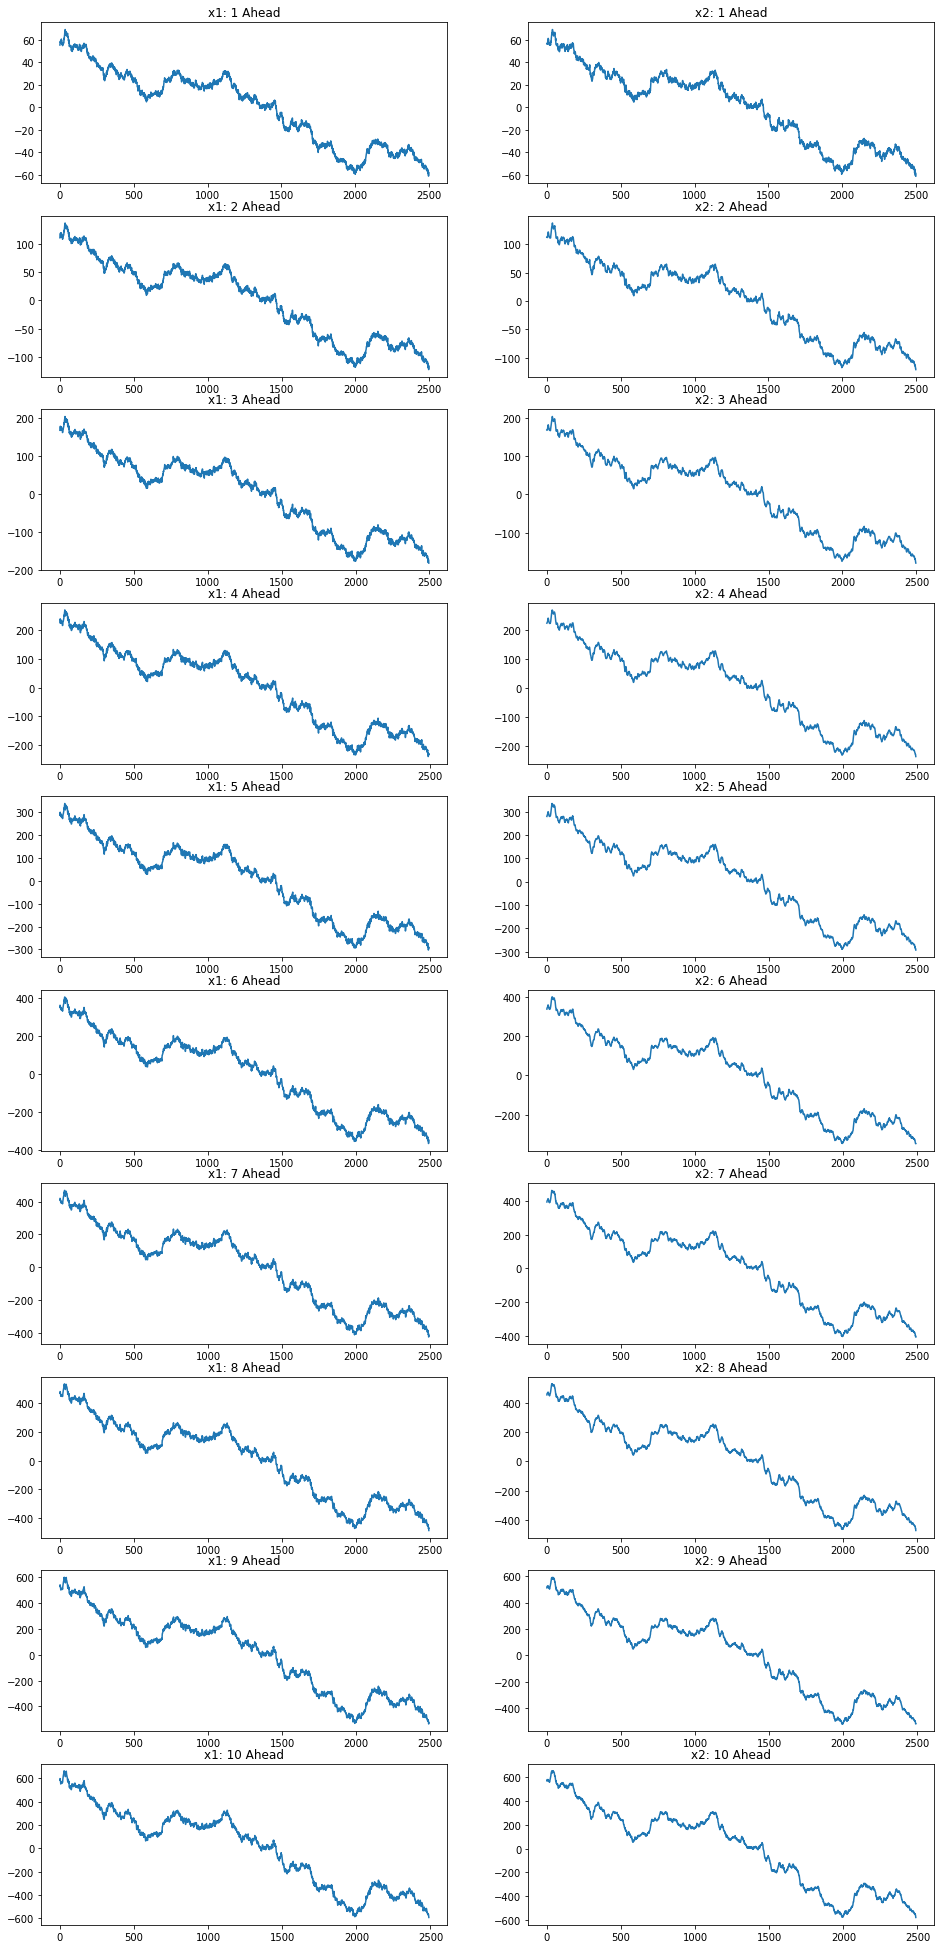





T = 2500 and Gamma = [-0.25  0.1 ]


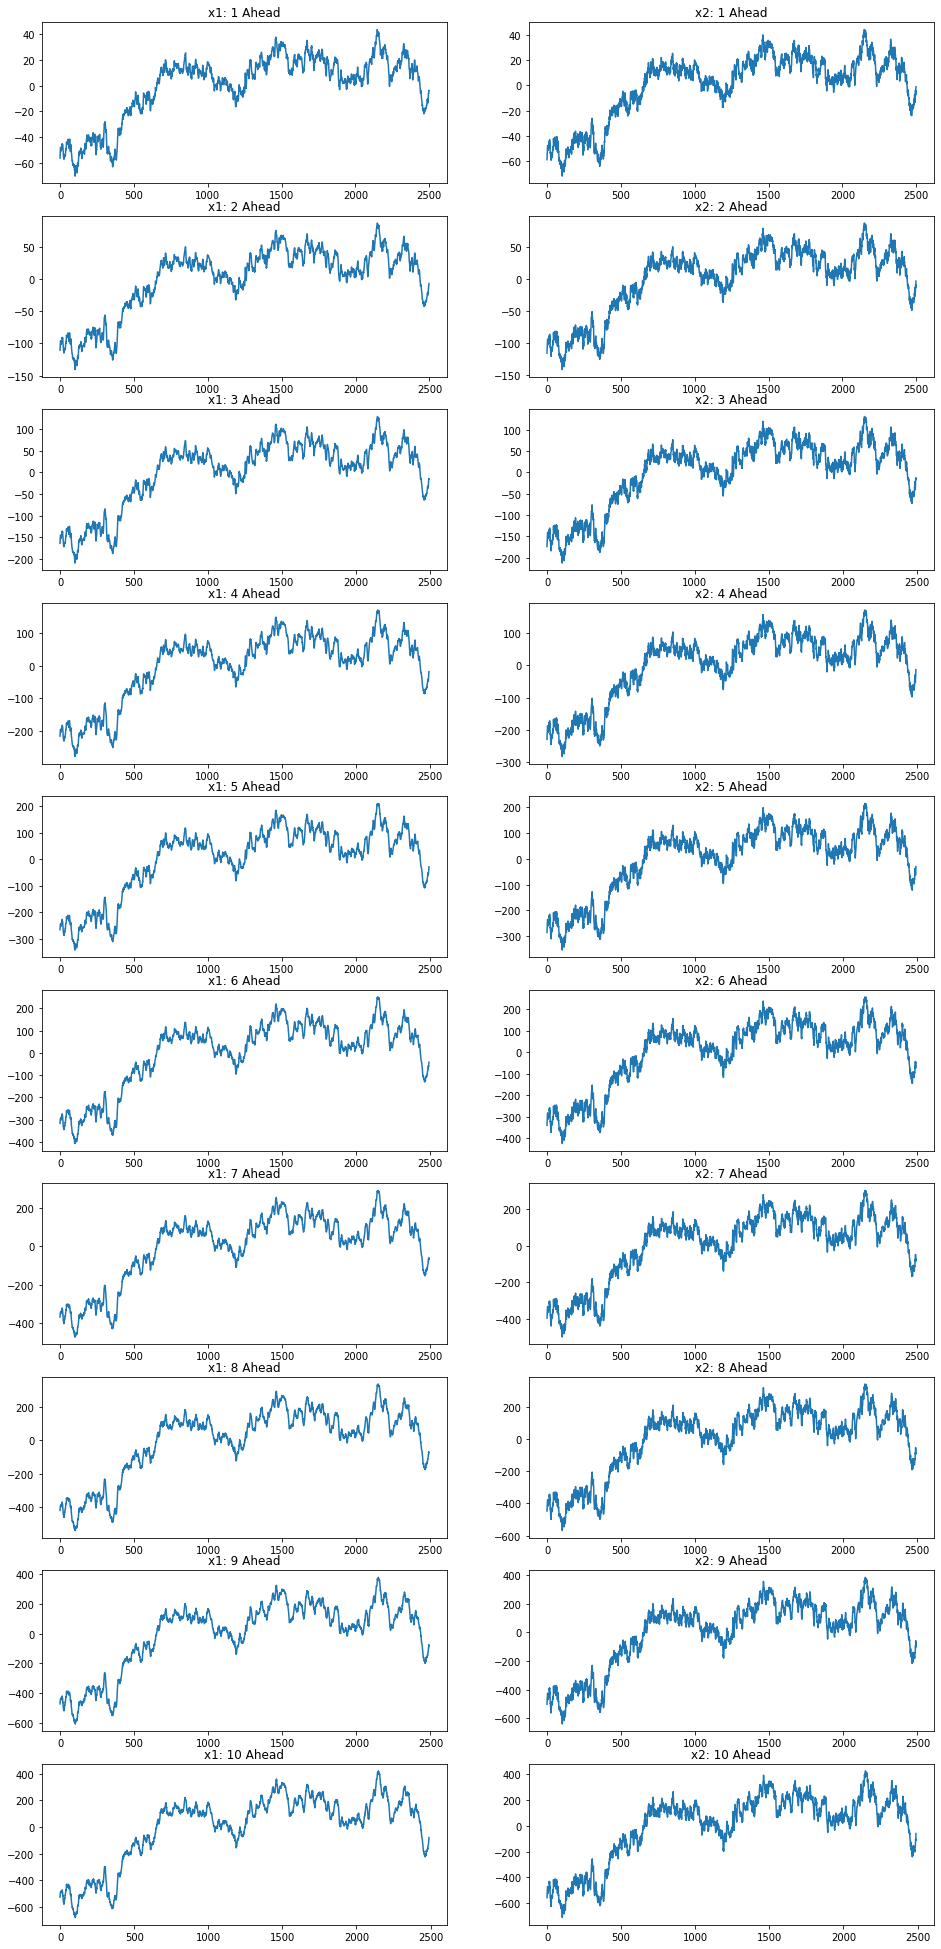

In [49]:
for T in [2500]:
    for i, g in enumerate([gamma1, gamma3]):
        LH_resid_df = {#"x1: {} Ahead".format(k): pd.Series(data = LH_result_dict["T:{}, Gamma:{}, K: {}, x1".format(T, i, k)].resids),
                       "x{}: {} Ahead".format(n, k): pd.Series(data = LH_result_dict["T:{}, Gamma:{}, K: {}, x{}".format(T, i, k, n)].resid) \
                                                         for k in range(1,10+1) for n in [1,2]
                }
        print("T = {} and Gamma = {}".format(T, g.flatten()))
        fig, axes = plt.subplots(10,2,figsize=(16,35))
        axes = axes.ravel()
        for i, (key, value) in enumerate(LH_resid_df.items()):
            x = np.arange(len(value))
            axes[i].plot(x, value)
            axes[i].set_title(key)
        plt.show()
        print("\n\n\n")

From the above plots of residuals, we can see that the errors are serial correlated. The patterns between different Ks look similar, although with a larger k, the line looks more smooth. The patterns between two variables also look very close.

### (e)

Here we will use one combination of T and gamma to compare variance-covariance matrices.

In [19]:
single_result = simulate_VECM1(alpha=alpha, phi=phi1, gamma=gamma3, nsample=2500)
LH_x1_white, LH_x2_white = estimate_LH(alpha, k, single_result, cov_type="HC1")
LH_x1_nonrobust, LH_x2_nonrobust = estimate_LH(alpha, k, single_result, cov_type="nonrobust")
LH_x1_NW, LH_x2_NW = estimate_LH(alpha, k, single_result, cov_type="HAC", cov_kwds={'maxlags':5, "kenel":"bartlett", "use_correction": True})
LH_x1_HH, LH_x2_HH = estimate_LH(alpha, k, single_result, cov_type="HAC", cov_kwds={'maxlags':5, "kenel":"uniform", "use_correction": True})

In [21]:
print("White variance-covariance matrix")
LH_x1_white.cov_params()

White variance-covariance matrix


array([[ 1.80191683, -0.0381531 ],
       [-0.0381531 ,  0.49955101]])

In [22]:
print("Nonrobust variance-covariance matrix")
LH_x1_nonrobust.cov_params()

Nonrobust variance-covariance matrix


array([[1.82398206, 0.05783511],
       [0.05783511, 0.50234543]])

In [23]:
print("Newey-West variance-covariance matrix")
LH_x1_NW.cov_params()

Newey-West variance-covariance matrix


array([[10.71137249, -0.39727672],
       [-0.39727672,  1.5058551 ]])

In [24]:
print("Hansen-Hodrick variance-covariance matrix")
LH_x1_HH.cov_params()

Hansen-Hodrick variance-covariance matrix


array([[10.71137249, -0.39727672],
       [-0.39727672,  1.5058551 ]])

Newey-West and Hansen-Hodrick variance-covariance matrices are most appropriate because it corrected both heteroskedasticity and autocorrelation

## Q5

In [25]:
q5_df = pd.read_csv("MFE230E_PS4_data.csv")
q5_df.rename(columns={'Unnamed: 0':"Date"}, inplace=True)
q5_df["Date"] = pd.to_datetime(q5_df["Date"], format="%Y-%m-%d")
q5_df["logP"] = np.log(q5_df["P"])
q5_df["logE"] = np.log(q5_df["E"])
q5_df["logP-logE"] = q5_df["logP"] - q5_df["logE"]
q5_df.set_index("Date", inplace=True)
display(q5_df.head())

,P,E,logP,logE,logP-logE
Date,,,,,
1960-12-31,58.11,3.103074,4.062338,1.132393,2.929945
1961-12-31,71.55,3.370005,4.270397,1.214914,3.055482
1962-12-31,63.10,3.666110,4.144721,1.299131,2.845590
1963-12-31,75.02,4.133602,4.317755,1.419149,2.898606
1964-12-31,84.75,4.762950,4.439706,1.560867,2.878839


### (a)

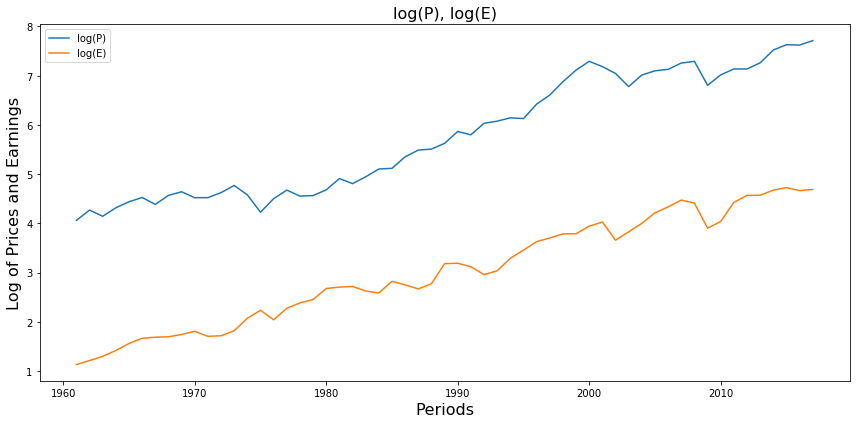

In [26]:
pt = q5_df['logP']
et = q5_df['logE']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

axes.plot(pt, label=r"log(P)")
axes.plot(et, label=r"log(E)")
axes.set_xlabel('Periods', fontsize=16)
axes.set_ylabel('Log of Prices and Earnings', fontsize=16)
axes.set_title(r"log(P), log(E)", fontsize=16)
axes.legend()
fig.tight_layout()

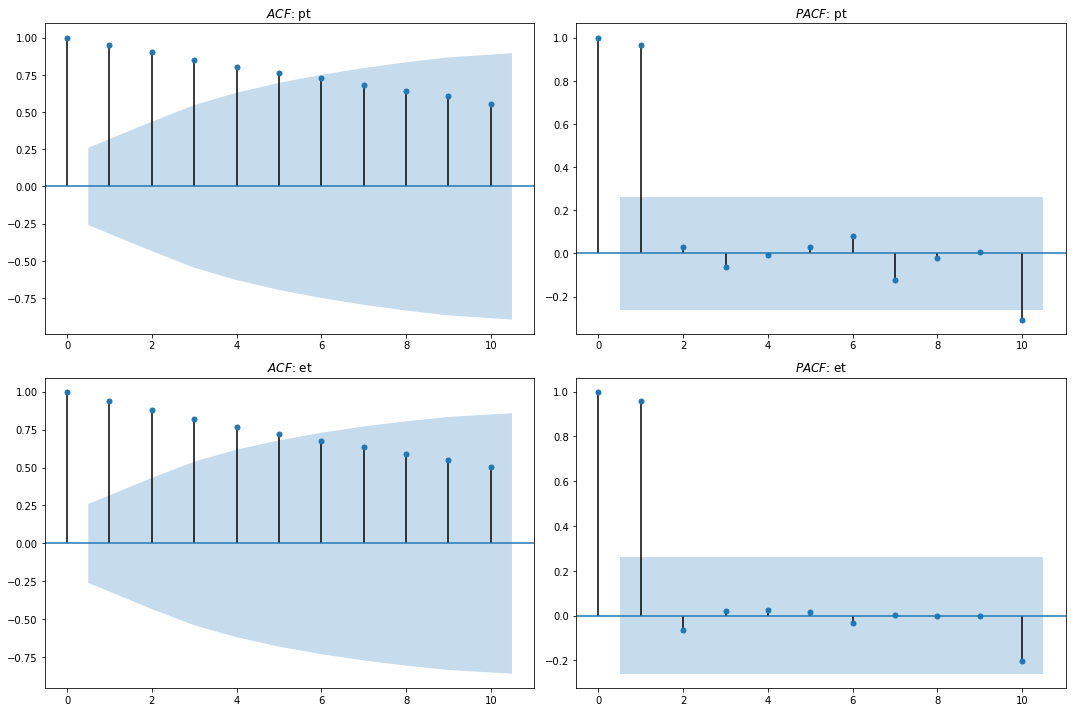

In [27]:
nlags = 10

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

plot_acf(pt,  ax=axes[0,0], lags=nlags, title="${\it ACF}$: pt")
plot_pacf(pt, ax=axes[0,1], lags=nlags, title="${\it PACF}$: pt")
plot_acf(et,  ax=axes[1,0], lags=nlags, title="${\it ACF}$: et")
plot_pacf(et, ax=axes[1,1], lags=nlags, title="${\it PACF}$: et")

fig.tight_layout()

In [28]:
ADF_logP_0, logP_p0 = ADF(q5_df["logP"], 0)
# ADF_logP_1, logP_p1 = ADF(q5_df["logP"], 1)
# ADF_logP_2, logP_p2 = ADF(q5_df["logP"], 2)
# ADF_logP_3, logP_p3 = ADF(q5_df["logP"], 3)
# ADF_logP_list = [ADF_logP_0, ADF_logP_1, ADF_logP_2, ADF_logP_3]
# logP_pvalue_list = [logP_p0, logP_p1, logP_p2, logP_p3]
# p = [0,1,2,3]
# ADF_logP_df = pd.DataFrame({"Number of Lags": p, "ADF Test": ADF_logP_list, "P-value": logP_pvalue_list})
ADF_logP_df = pd.DataFrame({"ADF Test": ADF_logP_0, "P-value": logP_p0}, index=[0])
display(ADF_logP_df)

,ADF Test,P-value
0,-0.226801,0.935251


In [29]:
ADF_logE_0, logE_p0 = ADF(q5_df["logE"], 0)
# ADF_logE_1, logE_p1 = ADF(q5_df["logE"], 1)
# ADF_logE_2, logE_p2 = ADF(q5_df["logE"], 2)
# ADF_logE_3, logE_p3 = ADF(q5_df["logE"], 3)
# ADF_logE_list = [ADF_logE_0, ADF_logE_1, ADF_logE_2, ADF_logE_3]
# logE_pvalue_list = [logE_p0, logE_p1, logE_p2, logE_p3]
# p = [0,1,2,3]
# ADF_logE_df = pd.DataFrame({"Number of Lags": p, "ADF Test": ADF_logE_list, "P-value": logE_pvalue_list})
ADF_logE_df = pd.DataFrame({"ADF Test": ADF_logE_0, "P-value": logE_p0}, index=[0])
display(ADF_logE_df)

,ADF Test,P-value
0,-0.880198,0.794424


Based a significance level of 5%, we are unable to reject the null hypotheses that log prices and log earnings are non-stationary. Therefore, we can conclude that log prices and log earnings are non-stationary.

### (b)

In [30]:
ADF_logPmE_0, logPmE_p0 = ADF(q5_df["logP-logE"], 0)
# ADF_logPmE_1, logPmE_p1 = ADF(q5_df["logP-logE"], 1)
# ADF_logPmE_2, logPmE_p2 = ADF(q5_df["logP-logE"], 2)
# ADF_logPmE_3, logPmE_p3 = ADF(q5_df["logP-logE"], 3)
# ADF_logPmE_list = [ADF_logPmE_0, ADF_logPmE_1, ADF_logPmE_2, ADF_logPmE_3]
# logPmE_pvalue_list = [logPmE_p0, logPmE_p1, logPmE_p2, logPmE_p3]
# p = [0,1,2,3]
# ADF_logPmE_df = pd.DataFrame({"Number of Lags": p, "ADF Test": ADF_logPmE_list, "P-value": logPmE_pvalue_list})
ADF_logPmE_df = pd.DataFrame({"ADF Test": ADF_logPmE_0, "P-value": logPmE_p0}, index=[0])
display(ADF_logPmE_df)

,ADF Test,P-value
0,-2.360608,0.153165


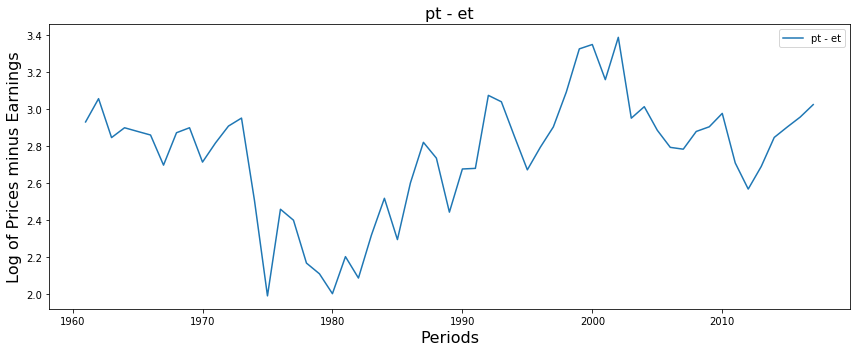

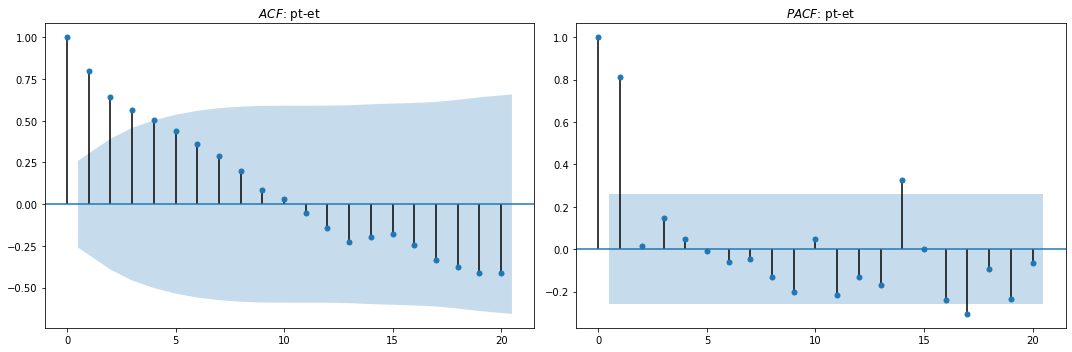

In [31]:
zt = q5_df["logP-logE"]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

axes.plot(zt, label=r"pt - et")
axes.set_xlabel('Periods', fontsize=16)
axes.set_ylabel('Log of Prices minus Earnings', fontsize=16)
axes.set_title(r"pt - et", fontsize=16)
axes.legend()

fig.tight_layout()


nlags = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_acf(zt,  ax=axes[0], lags=nlags, title="${\it ACF}$: pt-et")
plot_pacf(zt, ax=axes[1], lags=nlags, title="${\it PACF}$: pt-et")

fig.tight_layout()

Based on the ADF test result for the log price-earning ratio, with a significance level of 5%, we are unable to reject the null hypothesis that the process is non-stationary. Therefore, we conclude that the log price-earning ratio is non-stationary. Also, based on the ACF & PACF plots, the process is close to a ARMA(1,1) process.

### (c)

In [32]:
q5_Xt_array = q5_df[["logP", "logE"]].to_numpy()
q5_VECM1_logP, q5_VECM1_logE = estimate_VECM1(alpha, q5_Xt_array)

In [33]:
q5_VECM1_logP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.117
Model:                            OLS   Adj. R-squared (uncentered):              0.066
Method:                 Least Squares   F-statistic:                              2.446
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                      0.0742
Time:                        00:31:44   Log-Likelihood:                          21.843
No. Observations:                  55   AIC:                                     -37.69
Df Residuals:                      52   BIC:                                     -31.66
Df Model:                           3                                                  
Covariance Type:                  HC1                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0202      0.011      1.872      0.061      -0.001       0.041
x2            -0.0484      0.161     -0.301      0.764      -0.363       0.267
x3             0.0841      0.181      0.464      0.643      -0.271       0.439
==============================================================================
Omnibus:                       13.657   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.651
Skew:                          -1.108   Prob(JB):                     0.000659
Kurtosis:                       4.218   Cond. No.                         19.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [34]:
q5_VECM1_logE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.177
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              5.274
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                     0.00298
Time:                        00:31:44   Log-Likelihood:                          25.766
No. Observations:                  55   AIC:                                     -45.53
Df Residuals:                      52   BIC:                                     -39.51
Df Model:                           3                                                  
Covariance Type:                  HC1                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0193      0.010      1.920      0.055      -0.000       0.039
x2             0.1433      0.134      1.069      0.285      -0.119       0.406
x3             0.0426      0.125      0.340      0.734      -0.203       0.289
==============================================================================
Omnibus:                       16.029   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.210
Skew:                          -0.920   Prob(JB):                     2.04e-06
Kurtosis:                       5.838   Cond. No.                         19.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

From the above regression results we can see that only the log prices and log earnings ratio is significant. Basically, because log prices, log earnings, and the difference between log prices and log earnings are all non-stationary. Thus, there exists no cointegration and VECM is inappropriate in this case.

In [35]:
logP_BG = [BG(q5_VECM1_logP, i) for i in range(1, 10+1)]
logE_BG = [BG(q5_VECM1_logE, i) for i in range(1, 10+1)]
BG_df = pd.DataFrame(data = {"P-value for log P": logP_BG,
                             "P-value for log E": logE_BG}, index = range(1, 10+1))
BG_df.index.names = ["Lag"]
print("Breusch-Godfrey Test Result")
display(BG_df)

Breusch-Godfrey Test Result


,P-value for log P,P-value for log E
Lag,,
1,0.935742,0.674947
2,0.222312,0.022319
3,0.348121,0.034370
4,0.410763,0.031815
5,0.334302,0.031406
6,0.470630,0.023185
7,0.592321,0.038652
8,0.486655,0.029642
9,0.575058,0.044315


From the above Breush-Godfrey test results for log prices and log earnings, we can see that the errors of the log prices are not correlated, whereas the errors of the log earnings are autocorrelated.

In [36]:
def VECM1_regressors(alpha,Xt_array):
    x1t_vec = Xt_array[:, 0] # 1d array
    x2t_vec = Xt_array[:, 1]
    x1tm1_vec = x1t_vec[:-1]
    x2tm1_vec = x2t_vec[:-1]
    del_x1t_vec = np.diff(x1t_vec, axis=0) 
    del_x2t_vec = np.diff(x2t_vec, axis=0)
    del_x1tm1_vec = del_x1t_vec[:-1]
    del_x2tm1_vec = del_x2t_vec[:-1]
    del_x1t_vec = del_x1t_vec[1:]
    del_x2t_vec = del_x2t_vec[1:]
    ztm1 = alpha.item(0,0) * x1tm1_vec + alpha.item(1,0) * x2tm1_vec
    ztm1 = ztm1[1:]
    regressors = np.concatenate((ztm1.reshape(-1,1), del_x1tm1_vec.reshape(-1,1), del_x2tm1_vec.reshape(-1,1)), axis=1)
    return regressors

In [37]:
VECM_regressors = VECM1_regressors(alpha, q5_Xt_array)
wt_logP = White_test(q5_VECM1_logP, VECM_regressors)
wt_logE = White_test(q5_VECM1_logE, VECM_regressors)
wt_df = pd.DataFrame(data = {"P-value for log P": wt_logP,
                             "P-value for log E": wt_logE}, index = [0])
print("White Test Result")
display(wt_df)

White Test Result


,P-value for log P,P-value for log E
0,0.742521,0.919641


Based on the White-test result, we cannot reject the null hypothesis that errors are homoskedastic for both log prices and log earnings. In sum, we can conclude that the errors of log prices are not correlated and homoskedastic, whereas the errors of log earnings are autocorrelated and homoskedastic. However, given that the sample size is relatively small here, the White test might not be very conclusive. Thus, for safety, we should still aovid using non-robust variance-covariance matrix for log prices. In such cases,  White, Newey-West and Hansen-Hodrick variance-covariance matrices are appropriate for log prices. On the other hand, only the Newey-West and Hansen-Hodrick variance-covariance matrices are appropriate for log earnings due to autocorrelated errors.

### (d)

In [38]:
q5_LH_result_dict = {}
for k in range(1,5+1):
    LH_x1, LH_x2 = estimate_LH(alpha, k, q5_Xt_array, diff=True)
    q5_LH_result_dict["K: {}, logP".format(k)] = LH_x1
    q5_LH_result_dict["K: {}, logE".format(k)] = LH_x2

In [39]:
data_logP = {"{} Ahead".format(k): pd.Series(data = [q5_LH_result_dict["K: {}, logP".format(k)].params[1],
                                                  q5_LH_result_dict["K: {}, logP".format(k)].pvalues[1],
                                                  q5_LH_result_dict["K: {}, logP".format(k)].rsquared_adj],
                                        index = ["Coefficient", "P-value", "R^2"]) for k in range(1,5+1)
        }
LH_logP_coeff_df = pd.DataFrame(data_logP)
LH_logP_coeff_df.index.names = ["logP"]
data_logE = {"{} Ahead".format(k): pd.Series(data = [q5_LH_result_dict["K: {}, logE".format(k)].params[1],
                                                  q5_LH_result_dict["K: {}, logE".format(k)].pvalues[1],
                                                  q5_LH_result_dict["K: {}, logE".format(k)].rsquared_adj],
                                        index = ["Coefficient", "P-value", "R^2"]) for k in range(1,5+1)
        }
LH_logE_coeff_df = pd.DataFrame(data_logE)
LH_logE_coeff_df.index.names = ["logE"]
display(LH_logP_coeff_df)
display(LH_logE_coeff_df)

,1 Ahead,2 Ahead,3 Ahead,4 Ahead,5 Ahead
logP,,,,,
Coefficient,-0.101764,-0.158807,-0.192574,-0.257768,-0.322436
P-value,0.100101,0.074072,0.051958,0.014987,0.002226
R^2,0.022716,0.032829,0.040410,0.064572,0.081657


,1 Ahead,2 Ahead,3 Ahead,4 Ahead,5 Ahead
logE,,,,,
Coefficient,0.047251,0.065499,0.090259,0.093866,0.110726
P-value,0.502725,0.496627,0.375906,0.391386,0.280582
R^2,-0.009088,-0.010465,-0.005284,-0.003954,0.003627


### (e)

The error patterns for the long-horizon gressions


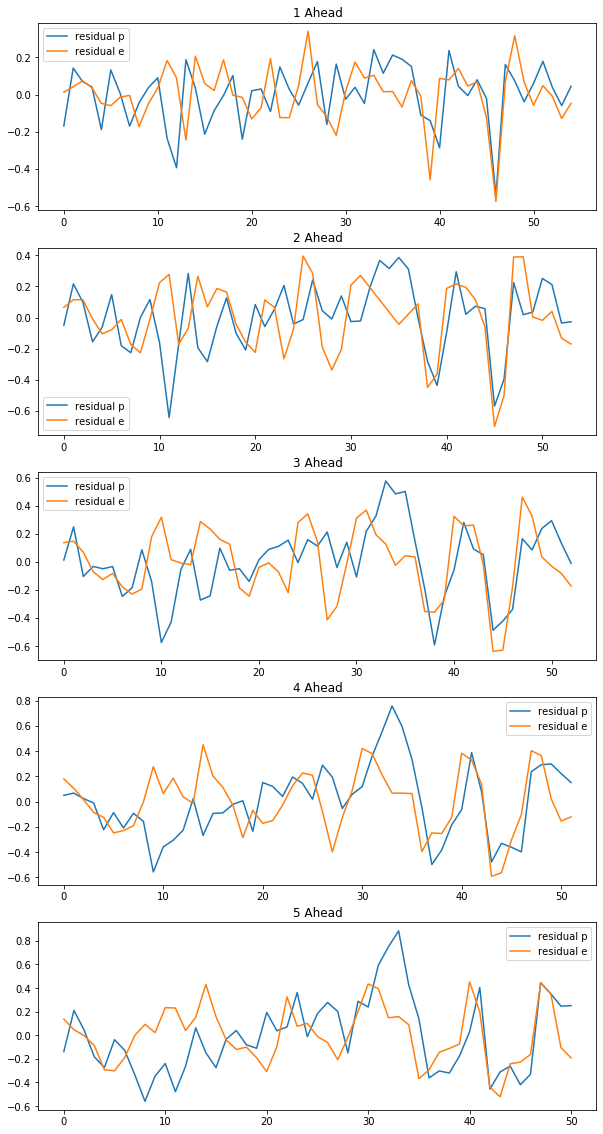

In [40]:
q5_LH_resid_df = {"log{}: {} Ahead".format(n, k): pd.Series(data = q5_LH_result_dict["K: {}, log{}".format(k, n)].resid) \
                                                 for k in range(1,5+1) for n in ["P", "E"]}
print("The error patterns for the long-horizon gressions")
fig, axes = plt.subplots(5,1,figsize=(10,20))
# axes = axes.ravel()
# for i, (key, value) in enumerate(q5_LH_resid_df.items()):
#     x = np.arange(len(value))
#     axes[i].plot(x, value)
#     axes[i].set_title(key)
    
for i in range(1, 5+1):
    p_resid = q5_LH_resid_df["logP: {} Ahead".format(i)]
    e_resid = q5_LH_resid_df["logE: {} Ahead".format(i)]
    x = np.arange(len(p_resid))
    axes[i-1].plot(x, p_resid, label=r"residual p")
    axes[i-1].plot(x, e_resid, label=r"residual e")
    axes[i-1].set_title("{} Ahead".format(i))
    axes[i-1].legend()
plt.show()

In [41]:
for k in range(1,5+1):
    logP_LH_result = q5_LH_result_dict["K: {}, logP".format(k)]
    logE_LH_result = q5_LH_result_dict["K: {}, logE".format(k)]
    logP_BG = [BG(logP_LH_result, i) for i in range(1, 10+1)]
    logE_BG = [BG(logE_LH_result, i) for i in range(1, 10+1)]
    BG_df = pd.DataFrame(data = {"P-value for log P": logP_BG,
                                 "P-value for log E": logE_BG}, index = range(1, 10+1))
    BG_df.index.names = ["Lag"]
    
    print("Breusch-Godfrey Test Result for the long-horizon regression with k = {}".format(k))
    display(BG_df)

Breusch-Godfrey Test Result for the long-horizon regression with k = 1


,P-value for log P,P-value for log E
Lag,,
1,0.651874,0.670465
2,0.397719,0.023567
3,0.586282,0.036658
4,0.559429,0.040112
5,0.476841,0.050861
6,0.631111,0.039417
7,0.728317,0.049232
8,0.555430,0.061177
9,0.667621,0.083508


Breusch-Godfrey Test Result for the long-horizon regression with k = 2


,P-value for log P,P-value for log E
Lag,,
1,0.013225,0.013499
2,0.002016,0.000009
3,0.000582,0.000037
4,0.000335,0.000016
5,0.000826,0.000058
6,0.002162,0.000170
7,0.001277,0.000459
8,0.003554,0.000363
9,0.006989,0.000698


Breusch-Godfrey Test Result for the long-horizon regression with k = 3


,P-value for log P,P-value for log E
Lag,,
1,0.000031,0.000296
2,0.000087,0.000001
3,0.000102,0.000005
4,0.000143,0.000022
5,0.000193,0.000052
6,0.000188,0.000142
7,0.000402,0.000257
8,0.000742,0.000382
9,0.001503,0.000797


Breusch-Godfrey Test Result for the long-horizon regression with k = 4


,P-value for log P,P-value for log E
Lag,,
1,0.000001,0.000096
2,0.000005,0.000017
3,0.000024,0.000019
4,0.000045,0.000055
5,0.000021,0.000103
6,0.000065,0.000146
7,0.000185,0.000464
8,0.000306,0.000994
9,0.000616,0.001375


Breusch-Godfrey Test Result for the long-horizon regression with k = 5


,P-value for log P,P-value for log E
Lag,,
1,0.000008,0.000166
2,0.000041,0.000043
3,0.000179,0.000165
4,0.000505,0.000061
5,0.000968,0.000142
6,0.000166,0.000127
7,0.000460,0.000372
8,0.000928,0.000895
9,0.000695,0.001449


From the Breusch-Godfrey test results, we can see that with a significance level of 5%, for k = 1, we almost couldn't reject the nul-hypothesis that errors are not auto-correlated for both log prices and log earnings. However, the pvalues for log earnings are much smaller than the log prices, which means we are much condifident that the errors for the case of log earnings are auto-correlated. For k = 2 to 5, we are able to reject the nul-hypothesis and we conclude that the errors are auto-correlated.

In [42]:
def LH_regressors(alpha, kahead, Xt_array):
    x1t_vec = Xt_array[:, 0] # 1d array
    x2t_vec = Xt_array[:, 1]
    x1tpk_vec_list = [x1t_vec[k:-(kahead-k)] for k in range(1,kahead)] + [x1t_vec[kahead:]]
    x2tpk_vec_list = [x2t_vec[k:-(kahead-k)] for k in range(1,kahead)] + [x2t_vec[kahead:]]
    x1t_vec = x1t_vec[:-(kahead+1)] 
    x2t_vec = x2t_vec[:-(kahead+1)]
    zt = alpha.item(0,0) * x1t_vec + alpha.item(1,0) * x2t_vec
    regressors = sm.add_constant(zt)
    return regressors

In [43]:
for k in range(1,5+1):
    white_regressors = LH_regressors(alpha,k,q5_Xt_array)
    logP_LH_result = q5_LH_result_dict["K: {}, logP".format(k)]
    logE_LH_result = q5_LH_result_dict["K: {}, logE".format(k)]
    wt_LH_logP = White_test(logP_LH_result, white_regressors)
    wt_LH_logE = White_test(logE_LH_result, white_regressors)
    wt_LH_df = pd.DataFrame(data = {"P-value for log P": wt_LH_logP,
                                 "P-value for log E": wt_LH_logE}, index = [0])
    print("White Test Result for the long-horizon regression with k = {}".format(k))
    display(wt_LH_df)

White Test Result for the long-horizon regression with k = 1


,P-value for log P,P-value for log E
0,0.976739,0.961038


White Test Result for the long-horizon regression with k = 2


,P-value for log P,P-value for log E
0,0.842142,0.933087


White Test Result for the long-horizon regression with k = 3


,P-value for log P,P-value for log E
0,0.56707,0.929313


White Test Result for the long-horizon regression with k = 4


,P-value for log P,P-value for log E
0,0.570428,0.855024


White Test Result for the long-horizon regression with k = 5


,P-value for log P,P-value for log E
0,0.315969,0.98956


Based on the White test results, we are unable to reject the null hypothesis with a significance level of 5%, and thus we conclude that the errors for the long-horizon regressions with k from 1 to 5 are homoskedastic. However these tests are particularly sensitive towards small or medium data issues and hence they should be checked further.

In [44]:
LH_errors_df = pd.DataFrame(data = {"Errors (log prices)": ["homoskedastic and not Auto-correlated",
                                                            "homoskedastic and Auto-correlated",
                                                            "homoskedastic and Auto-correlated",
                                                            "homoskedastic and Auto-correlated",
                                                            "homoskedastic and Auto-correlated"],
                                    "Errors (log Earnings)": ["homoskedastic and closely Auto-correlated",
                                                            "homoskedastic and Auto-correlated",
                                                            "homoskedastic and Auto-correlated",
                                                            "homoskedastic and Auto-correlated",
                                                            "homoskedastic and Auto-correlated"]
                                   }, index = range(1,5+1))
LH_errors_df.index.names = ["k"]
print("Summary Table for the heteroskedasticity and serial correlation patterns of the errors")
display(LH_errors_df)

Summary Table for the heteroskedasticity and serial correlation patterns of the errors


,Errors (log prices),Errors (log Earnings)
k,,
1,homoskedastic and not Auto-correlated,homoskedastic and closely Auto-correlated
2,homoskedastic and Auto-correlated,homoskedastic and Auto-correlated
3,homoskedastic and Auto-correlated,homoskedastic and Auto-correlated
4,homoskedastic and Auto-correlated,homoskedastic and Auto-correlated
5,homoskedastic and Auto-correlated,homoskedastic and Auto-correlated


### (f)

In [45]:
q5f_klist = [1,2,3,4,5]
for k in q5f_klist:
    LH_logP_white, LH_logE_white = estimate_LH(alpha, k, q5_Xt_array, cov_type="HC1", diff=True)
    LH_logP_nonrobust, LH_logE_nonrobust = estimate_LH(alpha, k, q5_Xt_array, cov_type="nonrobust", diff=True)
    LH_logP_NW, LH_logE_NW = estimate_LH(alpha, k, q5_Xt_array, cov_type="HAC", diff=True, cov_kwds={'maxlags':5, "kenel":"bartlett", "use_correction": True})
    LH_logP_HH, LH_logE_HH = estimate_LH(alpha, k, q5_Xt_array, cov_type="HAC", diff=True, cov_kwds={'maxlags':5, "kenel":"uniform", "use_correction": True})
    LH_logP_list = [LH_logP_nonrobust, LH_logP_white, LH_logP_NW, LH_logP_HH]
    LH_logE_list = [LH_logE_nonrobust, LH_logE_white, LH_logE_NW, LH_logE_HH]
    LH_SE_df = pd.DataFrame(data = {"log Price Standard Errors": [np.round(LH_logP.bse[1], decimals=4) for LH_logP in LH_logP_list],
                                    "log Earnings Standard Errors": [np.round(LH_logE.bse[1], decimals=4) for LH_logE in LH_logE_list]
                                   }, index = ["Non-robust", "White", "Newey-West", "Hansen-Hodrick"])
    print("Standard Erorrs for the long-horizon regressions with k = {}".format(k))
    display(LH_SE_df)

Standard Erorrs for the long-horizon regressions with k = 1


,log Price Standard Errors,log Earnings Standard Errors
Non-robust,0.0678,0.0659
White,0.0619,0.0705
Newey-West,0.0446,0.0586
Hansen-Hodrick,0.0446,0.0586


Standard Erorrs for the long-horizon regressions with k = 2


,log Price Standard Errors,log Earnings Standard Errors
Non-robust,0.0949,0.0975
White,0.0889,0.0963
Newey-West,0.0767,0.0920
Hansen-Hodrick,0.0767,0.0920


Standard Erorrs for the long-horizon regressions with k = 3


,log Price Standard Errors,log Earnings Standard Errors
Non-robust,0.1078,0.1059
White,0.0991,0.1019
Newey-West,0.1032,0.0994
Hansen-Hodrick,0.1032,0.0994


Standard Erorrs for the long-horizon regressions with k = 4


,log Price Standard Errors,log Earnings Standard Errors
Non-robust,0.1212,0.1050
White,0.1060,0.1095
Newey-West,0.1100,0.1025
Hansen-Hodrick,0.1100,0.1025


Standard Erorrs for the long-horizon regressions with k = 5


,log Price Standard Errors,log Earnings Standard Errors
Non-robust,0.1382,0.1018
White,0.1054,0.1026
Newey-West,0.1175,0.0943
Hansen-Hodrick,0.1175,0.0943


Usually white correction is done to the OLS regression in order to solve for the problem of heteroskedasticity in the errors but since the errors are autocorrelated, this is also not the most optimum one. Newey-West corrections are another option for removing the serial autocorrelation in errors by using triangular kernel weights. Hansen-Hodrick the same way uses uniform kernel in order to treat higher order serial correlation in errors and hence Newey West and Hansen-Hodrick are the most suitable standard error measures.Theoretically, Hansen-Hodrick standard errors work better for overlapping data. However, based on our estimation results, Newey-West and Hansen-Hodrick had exactly the same values.

### (g)

1. We saw that the data for log(P) and log(E) was non-stationary using the ADF test. We also plotted the ACF and PACF diagrams for the two time series data and realized that the data is non-stationary.

2. Given that the log price-earnings ratio was non-stationary, using either VECM or longhorizon regression would be inappropriate. However, since the p-value of the ADF test for the log price-earnings ratio was around 0.15 which was not very large, we can still deduce the behavior of returns and earnings economically. Based on the VECM result, gamma 1 and gamma 2 were both around 0.2, the VECM said both log prices and log earnings were error-correcting. However, looking at the long-horizon regression results, the coefficients were insignificant for the long-horizon regression in terms of log earnings with k = 1 to 5. In comparison, the coefficients for log prices were significant, and the corresponding p-values decreased and R squared increased with k from 1 to 5. Thus, we can conclude that the log prices were error-correcting, and more significant over longer periods.

4. 4. In this case, we should use the VAR in differences of the two time series to get a better sense of their forecastability.